In [1]:
import numpy as np
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
import scipy.optimize as op
import os
import emcee
import corner
datadir = os.getcwd()
datafile = '/betaPic_mag_res.dat'

%matplotlib inline

import emcee

In [2]:
times, mags = np.loadtxt(datadir + datafile, usecols=(0, 1)).T

In [3]:
#binning fuction
def bins(time, flux, binsize):
    n_bins = len(time) // binsize
    indexes = np.array_split(np.arange(len(time)), n_bins)
    print((indexes[0]).size)
    binned_time = np.array([np.mean(time[a]) for a in indexes])
    binned_flux = np.array([np.mean(flux[a]) for a in indexes])
    binned_flux_err = np.array([np.std(flux[a])/np.sqrt(a.size) for a in indexes])

    return (binned_time, binned_flux,binned_flux_err)

## Orbital dynamics


In [4]:
@u.quantity_input
def vcirc(m1:u.Msun,m2:u.Mjup,a:u.au)->u.km/u.s:
    """
    Circular orbital velocity of m2 about m1 at distance a

    Args:
        m1, m2: Primary and secondary masses
        a: semimajor axis

    Returns:
        velocity: circular orbital velocity

    >>> import astropy.units as u
    >>> vcirc(1.0 *u.M_sun, 1.0 * u.M_jup, 5.2 * u.au)
    <Quantity 13.06768412 km / s>
    """
    mu = c.G * (m1 + m2)
    vcirc = np.power(mu/a, 0.5)
    return vcirc


@u.quantity_input
def Ptoa(P:u.year, m1:u.M_sun, m2:u.M_jup)->u.au:
    """calculate orbital radius from period

    Args:
        P: orbital period
        m1, m2: Primary and secondary masses

    Returns:
        a: semi-major axis

    >>> import astropy.units as u
    >>> Ptoa(11.86*u.year, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 5.20222482 AU>
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)
    const = c.G / (4.*np.pi*np.pi)
    mu = m1 + m2
    a3 = P*P*const*mu
    aa = np.power(a3, 1./3.)
    
    return aa


## Calculate max velocity, minimum semimajor axis

Given that there's no other big eclipse, we can determine a minimum orbital period, and from that the orbital radius and largest circular velocity

In [5]:
Rs = 1.53 * c.R_sun # Wang 2016
Ms = 1.80 * c.M_sun # Wang 2016

Pmin = (1512. - 1411.) * u.day
print(Pmin)

101.0 d


In [6]:
amin = Ptoa(Pmin, Ms, 0.0 * c.M_sun)

print(amin)

0.5163047646925708 AU


In [7]:
vc = vcirc(Ms, 0.0*c.M_sun, amin)
print(vc)

55.612996630415445 km / s


In [8]:
t_star = (Rs / vc).to(u.day)
print(t_star)

0.2215253312435642 d


## Subroutines derived from Brogi 2012

In [9]:
def rc_hat(rc, a):
    'angular size of chord on star as seen from distance a'
    return np.arcsin(rc/(2*a))

def disk_intensity(thetad, rchat, a, Rstar, ulimb=0.79):
    'stellar disk intensity collapsed to 1D'
    s1 = np.power(np.sin(rchat/2),2) - np.power(np.sin(thetad),2)
    s1_negative = (s1<0)
    s1[s1_negative] = 0. # to prevent error with sqrt below
    s2 = 1 - (a/Rstar)*np.sqrt(s1)
    res = 1-(ulimb*s2)
    res[s1_negative] = 0
    return res

# make an exponential decay absorption for a comet tail
def rho(dtheta,ce,lam):
    'extinction cross section for comet'
    rho = ce * np.exp(-lam*dtheta)
    rho[(dtheta<0)] = 0 # no dust in front of the comet
    return rho

def impact_param(rc, Rstar):
    'impact parameter for a star and orbit around the star'
    d1 = rc/(2*Rstar)
    d2 = 1 - np.power(d1,2.)
    return np.sqrt(d2)

def rchordit(b, Rstar):
    'chord length for b'
    # b2 + (rc/2R)2 = 1
    # rc/2R = sqrt(1-b2)
    d1 = np.sqrt(1.-b*b)
    return d1*2*Rstar

## Select light curve points and initial guess for the fit

### convert mags to flux
$ m_a - m_b = -2.5\log(I_a/I_b)$

In [10]:
tmid = 1486.5 * u.day

tmin = 1485.0
tmax = 1488.0

m_zero = -0.0003 # estimate for no comet magnitude of star

(times_binned, mags_binned, mags_binned_error) = bins(times, mags, 15)

tmask = (times_binned>tmin) * (times_binned<tmax)
t = times_binned[tmask]
f = np.power(10,(mags_binned[tmask]-m_zero)/-2.5)
ferr = mags_binned_error[tmask]

16


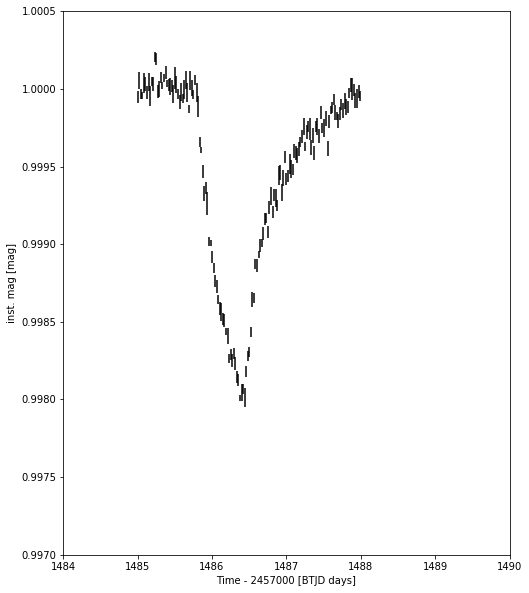

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.errorbar(t, f, yerr=ferr, c='k',fmt='none')
ax.set_ylim(0.9970, 1.0005)
ax.set_xlim(1484., 1490)

ax.set_xlabel('Time - 2457000 [BTJD days]')
ax.set_ylabel('inst. mag [mag]')

plt.show()

## Exocomet model

In [12]:
def modelexi(tin, y, yerr, tmid, bimpact, cmax, lam, P, Mstar, Rstar, ulimb, extra=False):

    tinmin = tin.min()
    tinmax = tin.max()
    tdelt = tinmax - tinmin
    
    # make a wider range of regularly spaced times so that convolution doesn't have round off error
    t_model = np.linspace(tinmin-tdelt, tinmax+tdelt, 10001)
    
    # convert time to orbital phase angle
    t_phase = (2*np.pi* (t_model - tmid) / P) * u.radian

    # convert period to semimajor axis
    a = Ptoa(P, Mstar, 0.0 * c.M_sun)

    # calculate size of a chord across the star
    rc = rchordit(bimpact, Rstar)
    
    # calculate angular size of chord across the star
    rchat = rc_hat(rc,a)
    
    # calculate intensity profile for a chord across the star
    I = disk_intensity(t_phase, rchat, a, Rstar, ulimb)
    Inorm = I / I.sum()
   
    # calculate comet tail
    rh = rho(t_phase, cmax, lam)
    
    # convolve two curves together to get 
    Itot = np.convolve(Inorm, rh,'same')
    
    # now use linear interpolator to find values of Itot at the t_inp times
    Itot_tin = np.interp(tin, t_model, Itot)

    if extra:
        return t_phase, Inorm, rh, 1 - Itot_tin
    
    return 1 - Itot_tin



In [36]:
# intial parameter 'guesses'
par = [1.48629045e+03, 4.73633661e-04, 3.67577405e-03, 8.23439812e+02, 2.29640594e+03]
labels = ["$t_{mid}$", "$b$", "$c_e$", "$\lambda$","$P$"]

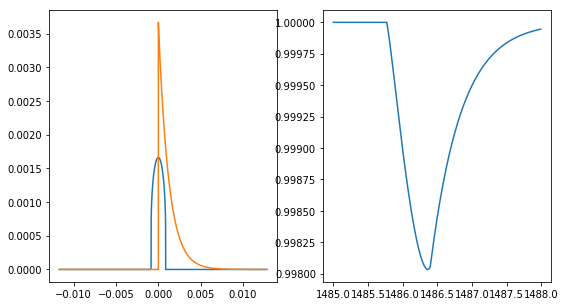

In [14]:
# get an idea of the density compared to the stellar size
t_phase, Inorm, rh, lc = modelexi(t*u.day, f, ferr, 
                                  par[0]*u.day, par[1], par[2], par[3]/u.radian, par[4]*u.day, Ms, Rs, 0.79,
                                  extra=True)

fig, ax = plt.subplots(1,2, figsize=(9,5))
ax[0].plot(t_phase, Inorm)
ax[0].plot(t_phase, rh)
ax[1].plot(t, lc)

In [15]:
ce = 0.0045
lamb = 1700.
period = 3636.

def lnlike(theta, t, f, ferr):
    tmid, impact, ce, lamb, period = theta
    model = modelexi(t*u.day, f, ferr, tmid*u.day, impact, ce, lamb/u.radian, period*u.day, Ms, Rs, 0.275)
    chi2 = np.power((f-model)/ferr,2.)
#     print(chi2)
    return -0.5*(np.sum(chi2))

nll = lambda *args: -lnlike(*args)

In [16]:
result = op.minimize(nll, par, method='nelder-mead', args=(t,f,ferr),
                     options={'maxiter':10000,'xtol': 1e-8, 'disp': True})

result

/usr/local/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Optimization terminated successfully.
         Current function value: 262.817626
         Iterations: 376
         Function evaluations: 750


 final_simplex: (array([[1.48629044e+03, 4.73020127e-04, 3.68132387e-03, 8.24939090e+02,
        2.29733817e+03],
       [1.48629044e+03, 4.73020127e-04, 3.68132387e-03, 8.24939090e+02,
        2.29733817e+03],
       [1.48629044e+03, 4.73020127e-04, 3.68132387e-03, 8.24939090e+02,
        2.29733817e+03],
       [1.48629044e+03, 4.73020127e-04, 3.68132387e-03, 8.24939090e+02,
        2.29733817e+03],
       [1.48629044e+03, 4.73020127e-04, 3.68132387e-03, 8.24939090e+02,
        2.29733817e+03],
       [1.48629044e+03, 4.73020127e-04, 3.68132387e-03, 8.24939090e+02,
        2.29733817e+03]]), array([262.81762641, 262.81762641, 262.81762641, 262.81762641,
       262.81762641, 262.81762641]))
           fun: 262.81762641143786
       message: 'Optimization terminated successfully.'
          nfev: 750
           nit: 376
        status: 0
       success: True
             x: array([1.48629044e+03, 4.73020127e-04, 3.68132387e-03, 8.24939090e+02,
       2.29733817e+03])

In [17]:
def plotfit(theta, t, f, ferr):
    tmid, impact, ce, lamb, period = theta
    model = modelexi(t*u.day, f, ferr, tmid*u.day, impact, ce, lamb/u.radian, period*u.day, Ms, Rs, 0.275)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 7), sharex=True)

    ax1.errorbar(t, f, yerr=ferr, c='k',fmt='none')
    ax1.set_ylim(0.9975, 1.0005)
    ax1.set_xlim(1484.75, 1488.25)
    ax2.set_position([0.17,0.1, 0.82, 0.2])
    ax1.set_position([0.17,0.3, 0.82, 0.65])

    ax2.set_xlabel('Time - 2457000 [BTJD days]')
    ax1.set_ylabel('Normalised intensity')

    ax1.plot(t, model, c='r')
    ax2.errorbar(t, f-model, yerr=ferr, c='k', fmt='none')
    redchisq = np.power((f-model)/ferr,2.)/f.size
    
#    print('$t_\{mid\}={:.2f}$ days'.format(tmid))
    
    ax2.axhline(y=0, color='k', linestyle='dotted')

    plt.show()
    return fig

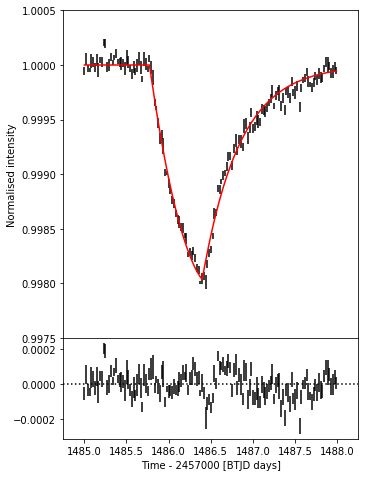

In [18]:
_ = plotfit(result['x'],t,f,ferr)

## emcee preparations

In [19]:
# prior - here we choose whether to restrict 0<b<1 or 0<b<0.001
def lnprior(theta):
    tmid, impact, ce, lamb, period = theta
    if 0 < impact < 0.001 and 0.0 < ce and 0.0 < lamb and period < 10000:
        return 0.0
    return -np.inf

In [20]:
# for setting b near zero
par = result['x']
par[1] = 1e-4

In [21]:
def lnprob(theta, t, f, ferr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, t, f, ferr)

# MCMC

In [22]:
ndim, nwalkers = 5, 100
pos = [par + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [23]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t, f, ferr), threads=4)

In [24]:
pos, prob, state = sampler.run_mcmc(pos, 1000)

/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [25]:
# save the chains to file
np.savez_compressed('chains.npz', sampler.chain, sampler.lnprobability)

In [26]:
print(sampler.get_autocorr_time(c=1))
print(sampler.acceptance_fraction)

[35.39759269 50.7690335  50.14708104 47.30491834 49.03751908]
[0.441 0.446 0.501 0.435 0.491 0.495 0.488 0.47  0.485 0.49  0.431 0.492
 0.487 0.481 0.5   0.478 0.505 0.523 0.437 0.468 0.491 0.495 0.457 0.467
 0.478 0.487 0.508 0.49  0.521 0.51  0.476 0.449 0.491 0.506 0.439 0.454
 0.503 0.491 0.495 0.445 0.483 0.473 0.485 0.536 0.479 0.428 0.497 0.488
 0.504 0.432 0.494 0.477 0.487 0.502 0.485 0.477 0.487 0.476 0.5   0.51
 0.452 0.494 0.485 0.481 0.497 0.477 0.454 0.519 0.487 0.5   0.519 0.543
 0.517 0.506 0.447 0.503 0.495 0.487 0.515 0.537 0.457 0.465 0.501 0.486
 0.494 0.473 0.445 0.461 0.48  0.499 0.448 0.481 0.489 0.447 0.49  0.483
 0.505 0.472 0.458 0.455]


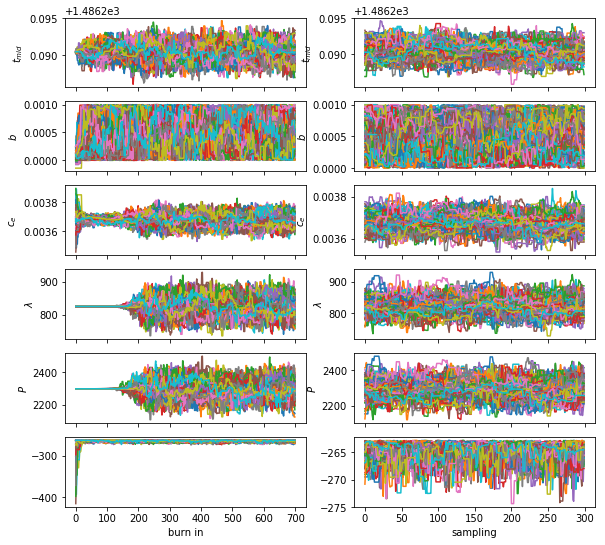

In [40]:
# see what the chains look like, skip a burn in period if desired
burn = 700
fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,9),sharex='col',sharey=False)

for j in range(nwalkers):
    ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        ax[i,0].set_ylabel(labels[i])

for j in range(nwalkers):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(sampler.chain[j,burn:,i])
        ax[i,1].set_ylabel(labels[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')
fig.savefig('chains.pdf')

In [41]:
# samples for deriving fitted parameters an uncertainties
samples = sampler.chain[:, burn:, :].reshape((-1, ndim))

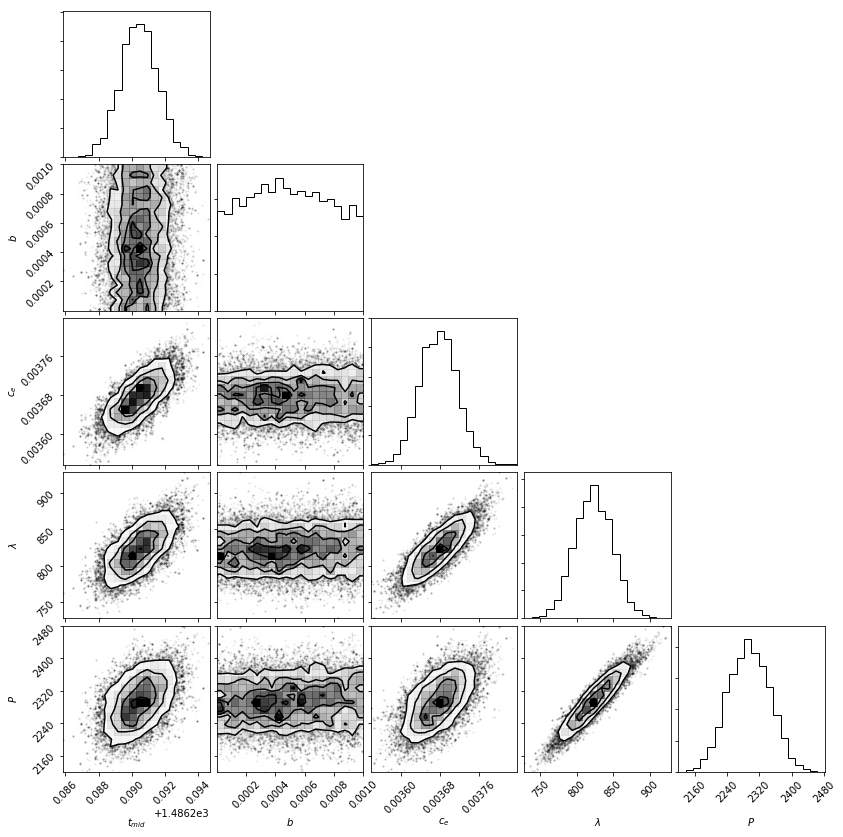

In [42]:
fig, ax = plt.subplots(5,5, figsize=(12,12))
fig = corner.corner(samples, labels=labels, show_titles=False, fig=fig)
fig.savefig("triangle-raw.pdf")

-263.0414714788731


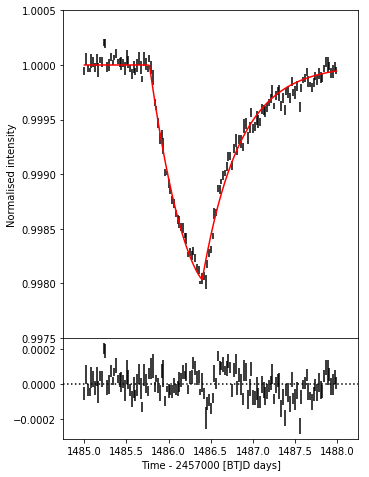

In [43]:
par = np.median(samples, axis=0)
print(lnprob(par,t,f,ferr))
fig = plotfit(par, t, f, ferr)
fig.savefig('onefit.pdf')

In [44]:
# now derived parameters
samples[:,0] = 24 * (samples[:,0] - 1486.)
samples[:,2] = 1e3*samples[:,2]
samples[:,3] = 1e3/samples[:,3]
samples[:,4] = vcirc(Ms, 0.0*u.M_sun, Ptoa(samples[:,4]*u.day, Ms, 0*u.M_sun))

In [45]:
# and cut out b if it's set to zero
samples = samples[:,[0,2,3,4]]
labels = ["$t_{mid}$ (h from 1486.0d)", "$c_e$ / $10^{-3}$", "$1/\lambda$ / $10^{-3}$ rad",
          "$v_{\\rm trans}$ / km s$^{-1}$"]

# labels = ["$t_{mid}$ (h from 1486.0d)", "$b$", $c_e$ / $10^{-3}$", "$1/\lambda$ / $10^{-3}$ rad",
#           "$v_{\\rm trans}$ / km s$^{-1}$"]

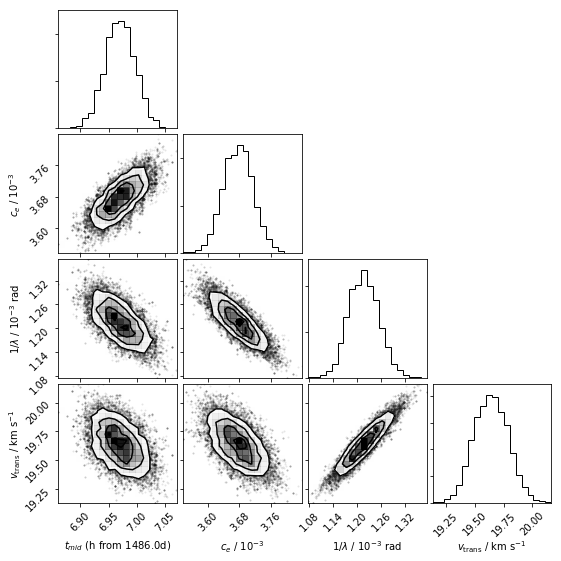

In [46]:
fig, ax = plt.subplots(4,4, figsize=(8,8))
fig = corner.corner(samples, labels=labels, show_titles=False, fig=fig)
fig.savefig("triangle.pdf")

In [47]:
# results
par = np.median(samples, axis=0)
print(par)
err = np.percentile(samples, [16, 84], axis=0) - par
print(err)
print(np.mean(np.abs(err), axis=0))

[ 6.97015172  3.67703996  1.21529161 19.63830368]
[[-0.02625079 -0.03862653 -0.03696855 -0.1463508 ]
 [ 0.02674179  0.0373025   0.03884291  0.14928751]]
[0.02649629 0.03796451 0.03790573 0.14781916]
